In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import yaml
import subprocess
import os

import runMops
import MopsAnalysis
import MopsReader
import MopsPlotter
from MopsTracker import MopsTracker
from MopsParameters import MopsParameters
from MopsResults import MopsResults

% matplotlib inline

In [2]:
dataDrive = "/Volumes/DataCenter/"
dataLocation = "neosimData/jpl/oc28-30EditedSSMIDs.txt"
subsampleLocation = "neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/"
runLocation = dataDrive + subsampleLocation + "run/"

! mkdir {dataDrive + subsampleLocation}

def arrayToSqlQuery(array):
    sample = ""
    for i in array:
        sample += str(i) + ', '

    sample = '(' + sample[0:-2] + ')'
    return sample

In [3]:
dets_df = MopsReader.readDetectionsIntoDataframe(dataDrive + dataLocation)
dets_df

,visitId,objectId,ra,dec,mjd,mag,snr
diaId,,,,,,,
0,1632978,0,176.493376,-11.783686,52390.965381,20.1233,14.68430
1,1632981,1,173.720592,-4.184379,52390.967172,20.0718,15.08580
2,1632982,2,174.183623,-2.062412,52390.967618,18.0567,100.80400
3,1632982,3,174.496816,-3.012748,52390.967618,20.0325,15.71120
4,1632982,1,173.721745,-4.183480,52390.967618,20.0708,15.08180
5,1632983,4,168.551646,-14.376801,52390.969452,19.6707,26.04840
6,1632988,1,173.733460,-4.174343,52390.972152,20.0851,15.15950
7,1632991,5,180.172511,-14.736185,52390.973526,18.8048,54.38470
8,1632996,6,184.203462,-24.600833,52390.976214,21.2715,5.01000


In [4]:
con = sql.connect(dataDrive + subsampleLocation + "limitedcase.db")
MopsReader.readDetectionsIntoDatabase(dataDrive + dataLocation, con)

In [5]:
limited = pd.read_sql_query("""
SELECT * FROM DiaSources
WHERE objectId IN %s;
""" % arrayToSqlQuery(np.loadtxt("missedObjectschiProb00_maxRMS005_trackAdd05.txt", dtype=int)), con)

In [6]:
limited

,diaId,visitId,objectId,ra,dec,mjd,mag,snr
0,7,1632991,5,180.172511,-14.736185,52390.973526,18.8048,54.38470
1,9,1632996,7,183.562673,-25.323302,52390.976214,15.4981,559.64900
2,10,1633003,5,180.215262,-14.725188,52390.979534,18.8211,54.64740
3,11,1633004,8,183.990336,-11.110103,52390.979982,19.8211,19.93470
4,12,1633007,9,179.068281,-5.609177,52390.981327,18.4735,82.51740
5,13,1633008,10,175.609316,-1.876057,52390.981774,17.0232,236.74800
6,14,1633009,10,175.608885,-1.876353,52390.982221,17.0216,236.41000
7,20,1633019,13,179.055780,-0.775773,52390.986740,20.0554,17.95180
8,21,1633020,10,175.604093,-1.879639,52390.987188,17.0290,237.67600
9,22,1633023,10,175.602177,-1.880952,52390.989173,17.0342,238.61800


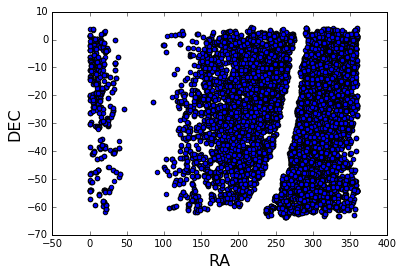

In [7]:
MopsPlotter.plotDataframe(limited)

In [8]:
subsampleData = dataDrive + subsampleLocation + "subsampledata.txt"
! rm -rf {subsampleData}

In [9]:
limited.to_csv(subsampleData, sep=" ", header=False, index=False)

In [10]:
nightly = dataDrive + subsampleLocation + "nightly/"

! rm -rf {nightly}
! mkdir {nightly}

In [11]:
call = ["python", os.getenv("MOPS_DIR") + "/bin/splitByNight.py", "-n", nightly, subsampleData]
subprocess.call(call);

In [12]:
parameters = MopsParameters(velocity_max="10.0", ra_acceleration_max="10.0", dec_acceleration_max="10.0")
tracker = MopsTracker(runLocation)
tracker.getDetections(nightly)

------- MOPS Parameters --------
Current Parameter Values:

---- findTracklets ----
	Maximum velocity:                         10.0
	Minimum velocity:                         0.0
---- collapseTracklets ----
	Right Ascension tolerance:                0.002
	Declination tolerance:                    0.002
	Angular tolerance:                        5
	Velocity tolerance:                       0.05
	Method:                                   greedy
	Use RMS filter:                           True
	Maximum RMS:                              0.001
---- purifyTracklets ----
	Maximum RMS:                              0.001
---- removeSubsets (tracklets) ----
	Remove subsets:                           False
	Keep only longest:                        False
---- makeLinkTrackletsInput_byNight.py ----
	Window size:                              15
---- linkTracklets ----
	Detection error threshold:                0.0004
	Maximum right ascension acceleration:     10.0
	Maximum declination acceleration:

In [13]:
parameters, tracker = runMops.runMops(parameters, tracker, overwrite=True)

------- Run MOPS -------
Running LSST's Moving Object Pipeline

Overwrite triggered: clearing tracker...

Found 72 detection files in /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/nightly/.

Saving parameters to /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/parameters.yaml

------- Run MOPS -------
Running findTracklets...
Completed running findTracklets.

Saving tracker to /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/tracker.yaml

------- Run MOPS -------
Running idsToIndices.py...
Completed running idsToIndices.py.

Saving tracker to /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/tracker.yaml

------- Run MOPS -------
Running collapseTracklets...
Completed running collapseTracklets.

------- Run MOPS -------
Running indicesToIds.py...
Completed running indicesToIds.py.

Saving tracker to /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObj

In [ ]:
parameters = MopsParameters.fromYaml(runLocation + "parameters.yaml")
tracker = MopsTracker.fromYaml(runLocation + "tracker.yaml")

Loading parameters from /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/parameters.yaml
Loading tracker from /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/tracker.yaml


In [ ]:
results, df = MopsAnalysis.analyze(parameters, tracker, fullDetFile=subsampleData, overwrite=True)

Initializing new results object...
Creating DiaSources table...
Creating AllObjects table...
Creating FoundObjects view...
Creating MissedObjects view...
Creating AllTracklets table...
Creating TrackletMembers table...
Creating Tracklets view...
Creating CollapsedTracklets view...
Creating PurifiedTracklets view...
Creating FinalTracklets view...

Reading full detections file into dataframe...
Counting findable objects as tracklets...
Counting findable objects as tracks...
Building objects dataframe...
Updating objects dataframe...
Reading full detections file into database...

Starting tracklet analysis for 72 nights...

Starting tracklet analysis for night 52391 at Wed Apr 13 10:58:50 2016

- Writing results to /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52391.results
- Checking file sizes...
- Reading input detections...
- Counting findable objects...
- Updating results object...
Saving results to /Volumes/DataCenter/neosimData/jpl_2016

In [23]:
results = MopsResults.fromYaml(runLocation + "results.yaml")

Loading results from /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results.yaml


In [24]:
results.performanceRatio

{'52391-52406': 0.2042042042042042,
 '52392-52406': 0.20923076923076922,
 '52393-52408': 0.22527472527472528,
 '52394-52408': 0.23011363636363635,
 '52395-52410': 0.21727748691099477,
 '52396-52411': 0.21212121212121213,
 '52397-52412': 0.21351351351351353,
 '52398-52413': 0.21637426900584794,
 '52399-52413': 0.21476510067114093,
 '52400-52415': 0.22592592592592592,
 '52401-52416': 0.2283464566929134,
 '52402-52417': 0.23333333333333334,
 '52403-52418': 0.2231404958677686,
 '52404-52419': 0.2028301886792453,
 '52405-52420': 0.20765027322404372,
 '52406-52420': 0.20588235294117646,
 '52408-52423': 0.1958762886597938,
 '52410-52425': 0.14814814814814814,
 '52411-52426': 0.10526315789473684,
 '52412-52427': 0.11320754716981132,
 '52413-52428': 0.08333333333333333,
 '52415-52430': 0.11585365853658537,
 '52416-52431': 0.11602209944751381,
 '52417-52432': 0.13548387096774195,
 '52418-52433': 0.15441176470588236,
 '52419-52434': 0.15441176470588236,
 '52420-52435': 0.14673913043478262,
 '5242

In [25]:
import MopsDatabase
import MopsPlotter

In [26]:
con = sql.connect(tracker.mainDatabase)
window_dbs = MopsDatabase.attachDatabases(con, tracker.windowDatabases)

Proceeding with the first 10 databases...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52391-52406.db to con as db0...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52392-52406.db to con as db1...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52393-52408.db to con as db2...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52394-52408.db to con as db3...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52395-52410.db to con as db4...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52396-52411.db to con as db5...
Attaching /Volumes/DataCenter/neosimData/jpl_2016_04_13_MissedObjects_DetErr0004_Accel00/run/results/52397-52412.db to con as db6...
Attaching /Volumes/DataCent

In [27]:
completion = len(MopsDatabase.findFoundObjects(con)) / float(limited["objectId"].nunique())

In [28]:
completion

0.1931372549019608

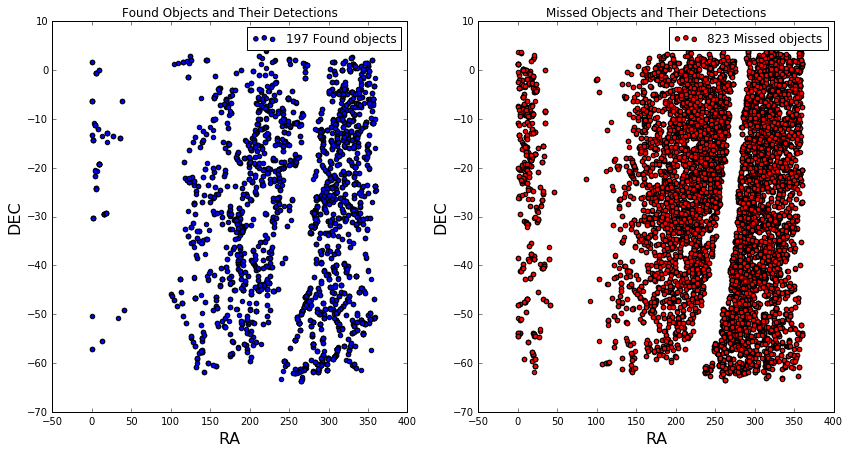

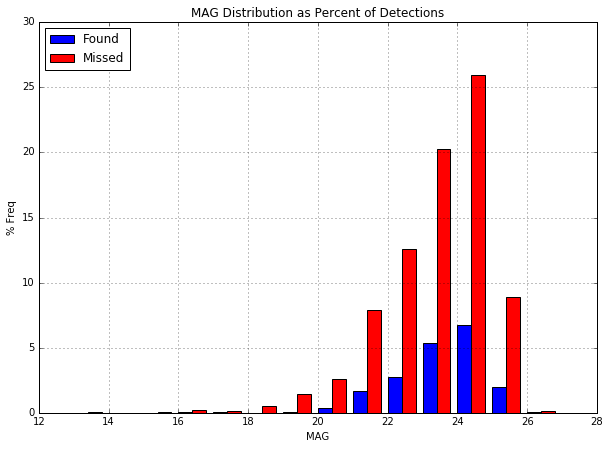

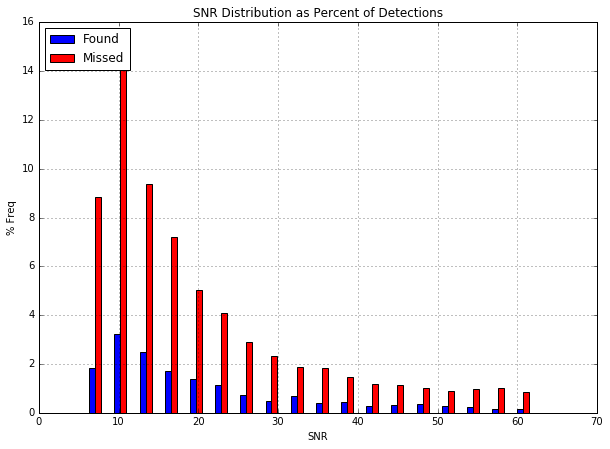

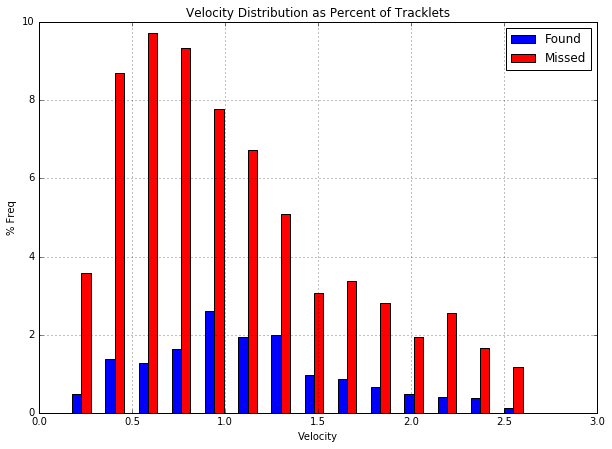

In [29]:
MopsPlotter.plotHists(con)